In [2]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/GMKI.jl")
include("../Inversion/KI.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

In [20]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

## Rosenbrock banana likelihood function

We will explore the question with the following inverse problem 

$$
\mathcal{G}(\theta) 
=
\begin{bmatrix}
\theta_{(2)} - \theta_{(1)}^2\\
\theta_{(1)}
\end{bmatrix} 
\qquad
\theta_{ref} = 
\begin{bmatrix}
1\\
1
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_{\eta_1}^2 & 0\\
0 & \sigma_{\eta_2}^2
\end{bmatrix} 
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the "uninformative" Gaussian prior $\mathcal{N}(0, 10^2 I)$.
     

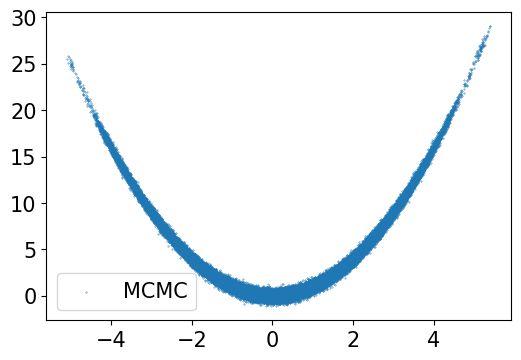

PyObject <matplotlib.legend.Legend object at 0x1b558e520>

In [24]:
function func_G(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return [θ₂ - θ₁^2; θ₁]
end

function log_prior(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return -(θ₁^2 + θ₂^2)/(2σ0^2)
end

function log_Rosenbrock(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    y₁, y₂ = func_G(θ)
    return -(y[1] - y₁)^2/(2ση₁^2) - (y[2] - y₂)^2/(2ση₂^2)  + log_prior(θ)
end

μ0, σ0 = [0.0;0.0], 10.0
Σ0 = [σ0^2 0.0;0.0  σ0^2]


ση₁, ση₂ = sqrt(1/10), sqrt(10)
Σ_η = [ση₁^2  0.0;  0.0  ση₂^2]
y = [0.0; 1.0]


# compute posterior distribution by MCMC

step_length = 0.1
n_ite = 10^7
us = RWMCMC_Run(log_Rosenbrock, μ0, step_length, n_ite);
everymarker = 100
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
n_burn_in, n_end = div(n_ite, 10), n_ite
ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
ax.legend()

## Gaussian Mixture Kalman Inversion

In [26]:
function forward(s_param::Setup_Param, θ::Array{Float64,1})
    return func_G(θ)
end


forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)

N_y, N_θ = 2, 2
# compute posterior distribution by UKI
update_freq = 1
N_iter = 100
N_modes = 3
θ0_w  = ones(N_modes)/N_modes
θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

θ0_mean[1, :]    .= [-3.0 ; 0]
θθ0_cov[1, :, :] .= diagm(1.0^2*ones(N_θ))
θ0_mean[2, :]    .= [3.0 ; 0]
θθ0_cov[2, :, :] .= diagm(1.0^2*ones(N_θ))
θ0_mean[3, :]    .= [0.0 ; 3.0]
θθ0_cov[3, :, :] .= diagm(1.0^2*ones(N_θ))

s_param_aug = Setup_Param(N_θ, N_y+N_θ)
y_aug = [y ; μ0]
Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
γ = 1.0
# Δt = γ/(1+γ)
ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")




# visualization 

# Visualize different iterations
for iter  = 1:plot_every:length(ukiobj.θ_mean)
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    # plot UKI results 
    
    
    if Run_MCMC
        ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
    end
    
    Nx = 1000
    xxs, zzs = zeros(N_modes, Nx), zeros(N_modes, Nx)
    θ_min = minimum(ukiobj.θ_mean[iter][:,1] .- 5sqrt.(ukiobj.θθ_cov[iter][:,1,1]))
    θ_max = maximum(ukiobj.θ_mean[iter][:,1] .+ 5sqrt.(ukiobj.θθ_cov[iter][:,1,1]))

    for i =1:N_modes
        xxs[i, :], zzs[i, :] = Gaussian_1d(ukiobj.θ_mean[iter][i,1], ukiobj.θθ_cov[iter][i,1,1], Nx, θ_min, θ_max)
        zzs[i, :] *= exp(ukiobj.logθ_w[iter][i])
        ax.plot(xxs[i,:], zzs[i,:], marker= "o", linestyle=":", color="C"*string(i), fillstyle="none", markevery=100, label="UKI Modal "*string(i))
    end
    ax.plot(xxs[1,:], sum(zzs, dims=1)', marker= "*", linestyle="-", color="C0", fillstyle="none", markevery=100, label="UKI")


    # plot UKI results 
    Nx = 100; Ny = 200
    for i =1:N_modes
        uki_θ_mean = uki_obj.θ_mean[ite][i, :]
        uki_θθ_cov = uki_obj.θθ_cov[ite][i, :, :]
        X,Y,Z = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny)
        ax.contour(X, Y, Z, 50)
    end

    ax.legend()
end


nrows, ncols = 1, 1
fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
θ_w = exp.(hcat(ukiobj.logθ_w...))
for i =1:N_modes
    ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
end
ax.legend()


("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :]) = ("mode : ", 1, [1.0 0.0; 0.0 1.0], [-3.0, 0.0])
("mode : ", i, θ_w[i], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 1, 0.3333333333333333, 0.5414426145769261, 0.9378061178301692)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :]) = ("mode : ", 2, [1.0 0.0; 0.0 1.0], [3.0, 0.0])
("mode : ", i, θ_w[i], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 2, 0.3333333333333333, 0.5466615694383236, 0.9468456128125183)
("mode : ", i, θθ_cov[i, :, :], θ_mean[i, :]) = ("mode : ", 3, [1.0 0.0; 0.0 1.0], [0.0, 3.0])
("mode : ", i, θ_w[i], θ_w_p[i], sum(ws) / N_ens) = ("mode : ", 3, 0.3333333333333333, 0.5105665044573241, 0.8843271263629271)
logθ_w_n = [35507.557287801676, 36973.75197853803, 773.3806405369185]


┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:81
┌ Info: ("updata : θ_mean = ", [-3.0 0.0; 3.0 0.0; 0.0 3.0], " θ_p_mean = ", [-3.1125862655010055 -0.16157099817084525; 3.1451656498835594 -0.1518145664226083; 0.0038849247921644786 3.160749724061864])
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:530


LoadError: PosDefException: matrix is not Hermitian; Cholesky factorization failed.

## Double banana likelihood function

We will explore the question with the following inverse problem 

$$
\begin{align*}
y = 
\log
\Bigl(
(1 - \theta_{(1)})^2 + 100(\theta_{(2)} - \theta_{(1)}^2)^2
\Bigr)
+\eta
\qquad 
\theta_{ref} = 
\begin{bmatrix}
0\\
0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
0.3^2 
\end{bmatrix} 
\end{align*}
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the Gaussian prior $\mathcal{N}(0, 1^2 I)$.
     

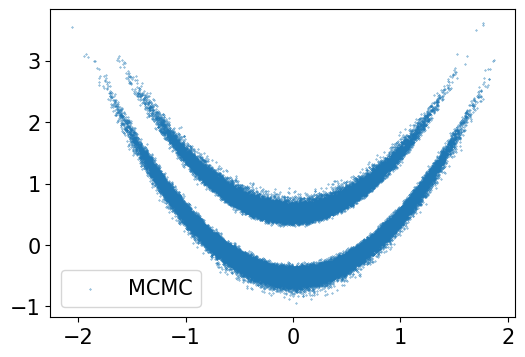

┌ Info: ("y = ", [3.258096538021482])
└ @ Main In[18]:32


PyObject <matplotlib.legend.Legend object at 0x1a13a2580>

In [18]:
function func_G(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return [log((1 - θ₁)^2 + 100(θ₂ - θ₁^2)^2);]
end

function log_prior(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return -(θ₁^2 + θ₂^2)/σ0^2/2
end

function log_double_banana(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return -(y[1] - func_G(θ)[1])^2/ση^2/2 + log_prior(θ)
end

μ0, σ0 = [0.0;0.0], 1.0
Σ0 = [σ0^2 0.0;0.0  σ0^2]

ση = 0.3
y = func_G([0.0; 0.5])

@info "y = ", y

# compute posterior distribution by MCMC

step_length = 0.1
n_ite = 10^7
us = RWMCMC_Run(log_double_banana, μ0, step_length, n_ite);
everymarker = 100
fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
n_burn_in, n_end = div(n_ite, 10), n_ite
ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
ax.legend()

In [ ]:
function forward(s_param::Setup_Param, θ::Array{Float64,1})
    return func_G(θ)
end


forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)

N_y, N_θ = 1, 2
# compute posterior distribution by UKI
update_freq = 1
N_iter = 100
N_modes = 3
θ0_w  = ones(N_modes)/N_modes
θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

θ0_mean[1, :]    .= [-3.0 ; 0]
θθ0_cov[1, :, :] .= diagm(1.0^2*ones(N_θ))
θ0_mean[2, :]    .= [3.0 ; 0]
θθ0_cov[2, :, :] .= diagm(1.0^2*ones(N_θ))
θ0_mean[3, :]    .= [0.0 ; 3.0]
θθ0_cov[3, :, :] .= diagm(1.0^2*ones(N_θ))

s_param_aug = Setup_Param(N_θ, N_y+N_θ)
y_aug = [y ; μ0]
Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
γ = 1.0
# Δt = γ/(1+γ)
ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")




# visualization 

# Visualize different iterations
for iter  = 1:plot_every:length(ukiobj.θ_mean)
    nrows, ncols = 1, 1
    fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
    # plot UKI results 
    
    
    if Run_MCMC
        ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
    end
    
    Nx = 1000
    xxs, zzs = zeros(N_modes, Nx), zeros(N_modes, Nx)
    θ_min = minimum(ukiobj.θ_mean[iter][:,1] .- 5sqrt.(ukiobj.θθ_cov[iter][:,1,1]))
    θ_max = maximum(ukiobj.θ_mean[iter][:,1] .+ 5sqrt.(ukiobj.θθ_cov[iter][:,1,1]))

    for i =1:N_modes
        xxs[i, :], zzs[i, :] = Gaussian_1d(ukiobj.θ_mean[iter][i,1], ukiobj.θθ_cov[iter][i,1,1], Nx, θ_min, θ_max)
        zzs[i, :] *= exp(ukiobj.logθ_w[iter][i])
        ax.plot(xxs[i,:], zzs[i,:], marker= "o", linestyle=":", color="C"*string(i), fillstyle="none", markevery=100, label="UKI Modal "*string(i))
    end
    ax.plot(xxs[1,:], sum(zzs, dims=1)', marker= "*", linestyle="-", color="C0", fillstyle="none", markevery=100, label="UKI")


    # plot UKI results 
    Nx = 100; Ny = 200
    for i =1:N_modes
        uki_θ_mean = uki_obj.θ_mean[ite][i, :]
        uki_θθ_cov = uki_obj.θθ_cov[ite][i, :, :]
        X,Y,Z = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny)
        ax.contour(X, Y, Z, 50)
    end

    ax.legend()
end


nrows, ncols = 1, 1
fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=true, sharey=true, figsize=(6,6))
θ_w = exp.(hcat(ukiobj.logθ_w...))
for i =1:N_modes
    ax.plot(θ_w[i, :], "--o", label="mode"*string(i))
end
ax.legend()

